### `DemandSupplySimulation` 環境設定方法

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f environment.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f environment.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f environment.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f environment.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Install conda mini.

### Frequently Used Commands
1. **List Existing Environment**  
   - Command: `conda env list`  
     <button onclick="navigator.clipboard.writeText('conda env list')">Copy Command</button>

# 投資最適化計算


年次: 2024年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 0%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 15.30it/s]
INFO:linopy.io: Writing time: 2.77s
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 15.30it/s]
INFO:linopy.io: Writing time: 2.77s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.07e+11
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.07e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, St

✓ 2024年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2024.nc contains: stores, carriers, sub_networks, buses, loads, generators, links


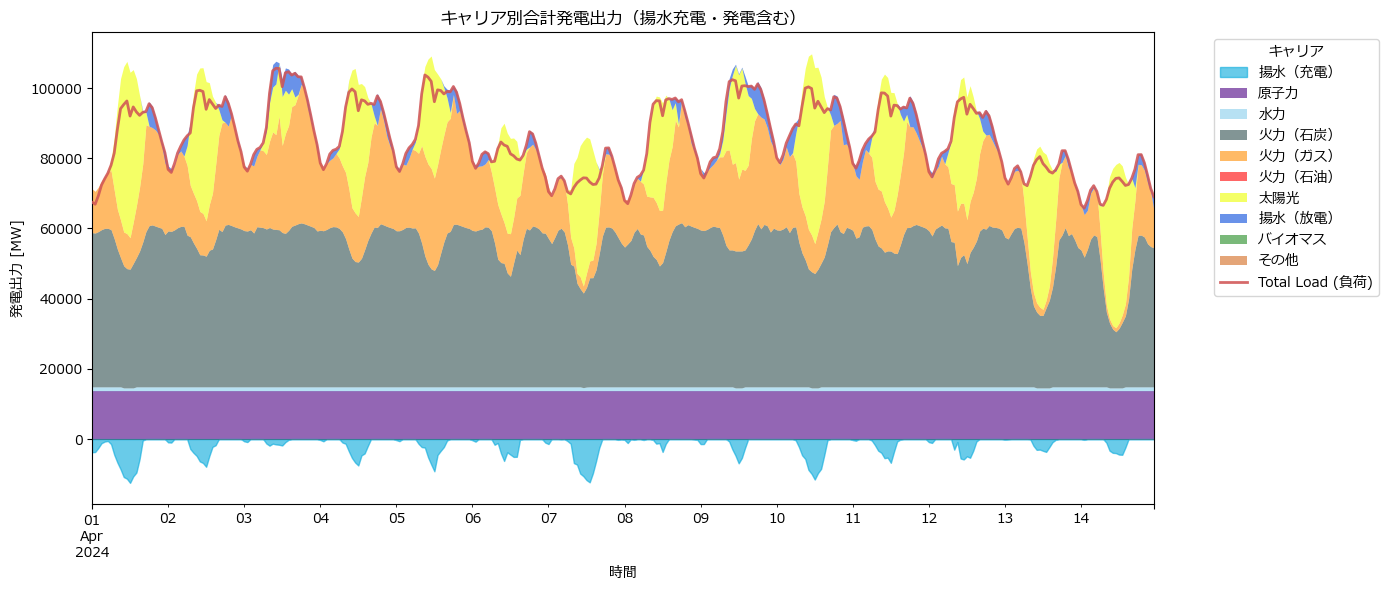


年次: 2030年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 10%)
最適化を実行中... (需要変化率: 10%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 11.32it/s]
INFO:linopy.io: Writing time: 2.91s
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 11.32it/s]
INFO:linopy.io: Writing time: 2.91s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.40e+11
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.40e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, St

✓ 2030年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2030.nc contains: stores, carriers, sub_networks, buses, loads, generators, links


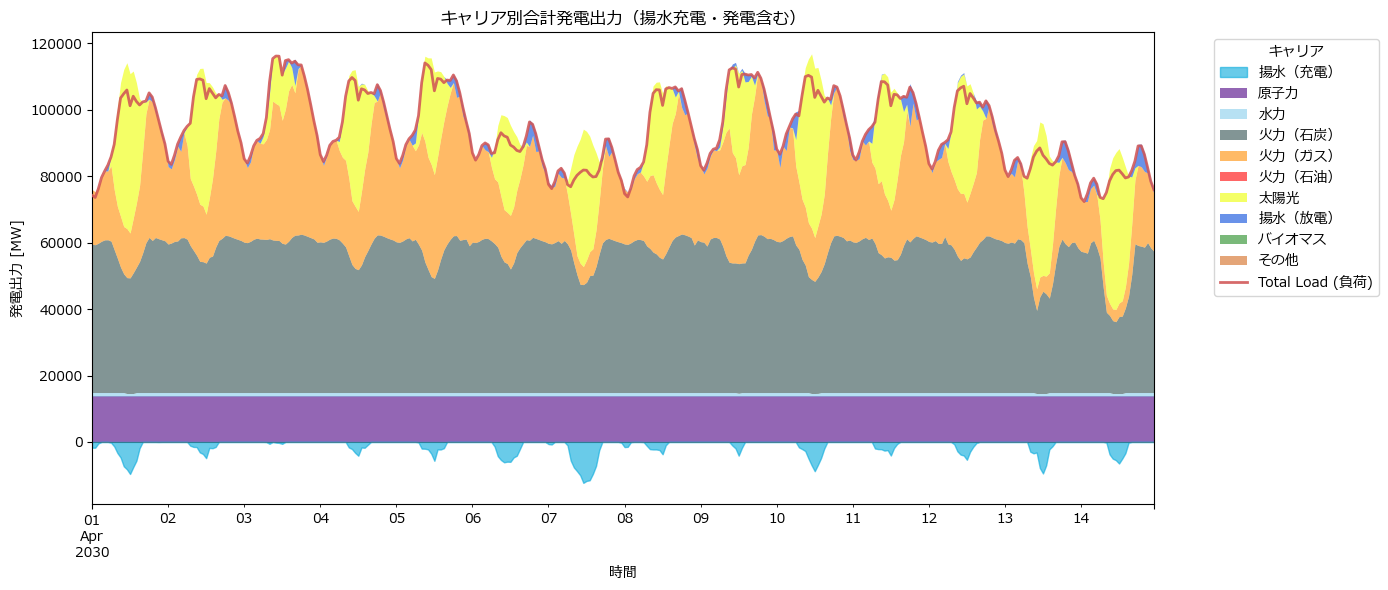


年次: 2040年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 20%)
最適化を実行中... (需要変化率: 20%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s]
INFO:linopy.io: Writing time: 3.0s
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s]
INFO:linopy.io: Writing time: 3.0s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.74e+11
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 2.74e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Stor

✓ 2040年の最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2040.nc contains: stores, carriers, sub_networks, buses, loads, generators, links


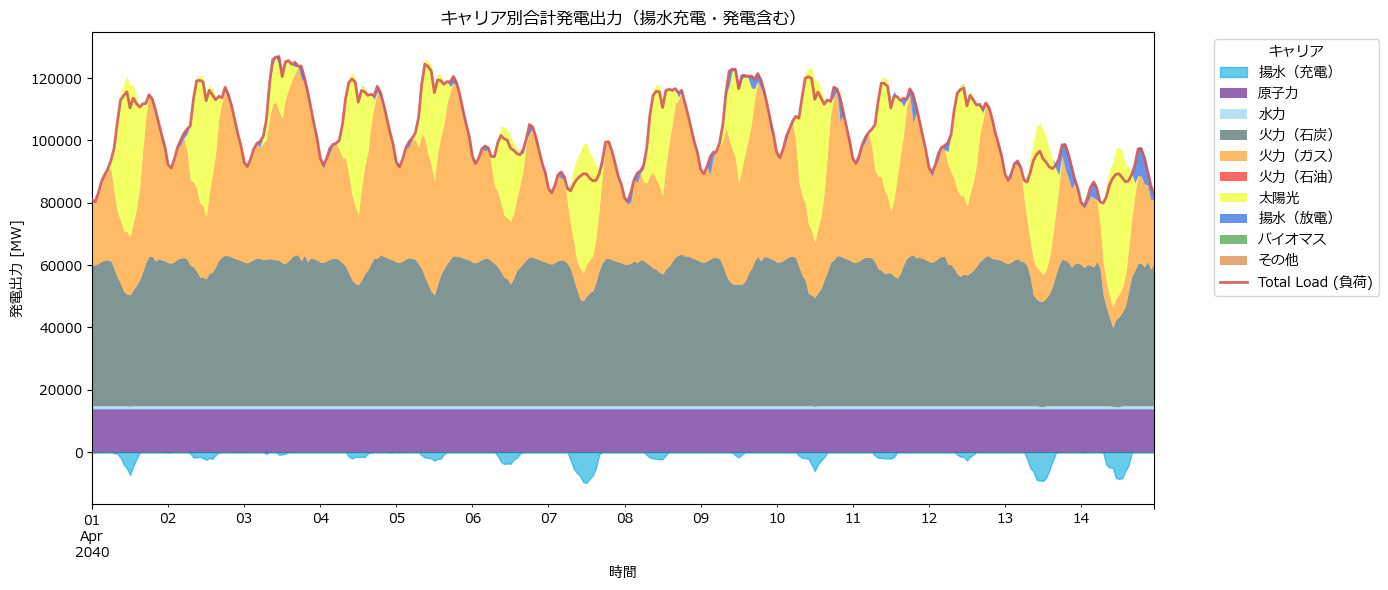


年次: 2050年の最適化を開始


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
最適化を実行中... (需要変化率: 30%)
最適化を実行中... (需要変化率: 30%)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 16.12it/s]
INFO:linopy.io: Writing time: 2.62s
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 16.12it/s]
INFO:linopy.io: Writing time: 2.62s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 3.08e+11
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 127680 primals, 459564 duals
Objective: 3.08e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, St

✓ 2050年の最適化が完了しました。


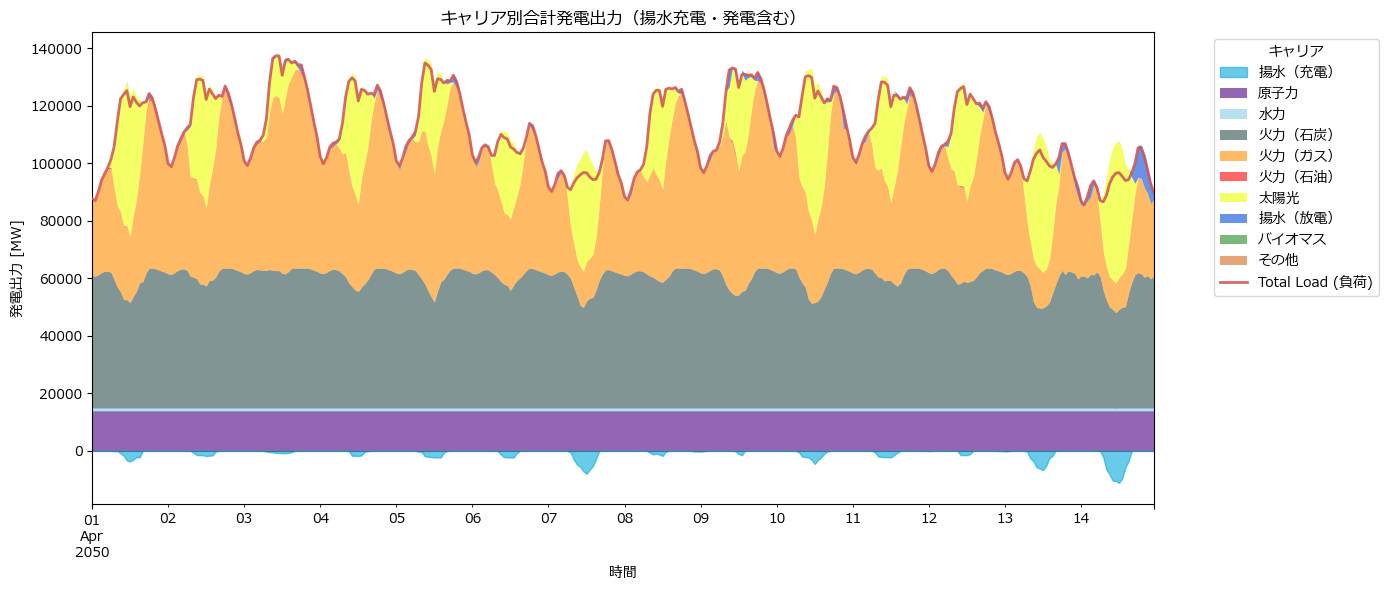


全年次の最適化が完了しました！

結果サマリー:
        total_cost  total_demand
2024  2.066867e+11  2.885654e+07
2030  2.398049e+11  3.174219e+07
2040  2.737784e+11  3.462785e+07
2050  3.083681e+11  3.751350e+07


In [46]:
from linopy import Model

# 複数年断面での最適電源構成計算
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt

# モジュールインポート（既にインポートされている場合はスキップ）
sys.path.append(os.getcwd())
import src.preprocess_data as preprocess_data
import src.analyze_results as analyze_results

importlib.reload(preprocess_data)
importlib.reload(analyze_results)
warnings.filterwarnings("ignore", category=UserWarning, module="pypsa")

# 出力ディレクトリ作成
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

# 分析対象年のリスト
analysis_years = [2024, 2030, 2040, 2050]

# 各年の需要変化率（2024年比）
demand_changes = {
    2024: 0,
    2030: 10,
    2040: 20,
    2050: 30
}

file_name = "./data/raw/pypsa-japan-10BusModelV6.xlsx"

# Ramp制約追加関数
def add_ramp_constraints(n, snapshots):
    
    if hasattr(n, 'links') and len(n.links) > 0:
        links_with_ramp_up = n.links[n.links['ramp_limit_up'].notna() & (n.links['ramp_limit_up'] > 0)].index
        if len(links_with_ramp_up) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            ramp_up_limit = n.links.loc[links_with_ramp_up, 'ramp_limit_up'] * n.links.loc[links_with_ramp_up, 'p_nom']
            n.model.add_constraints(p_diff.loc[:, links_with_ramp_up] <= ramp_up_limit, name="Link-ramp_limit_up")
        
        links_with_ramp_down = n.links[n.links['ramp_limit_down'].notna() & (n.links['ramp_limit_down'] > 0)].index
        if len(links_with_ramp_down) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            ramp_down_limit = n.links.loc[links_with_ramp_down, 'ramp_limit_down'] * n.links.loc[links_with_ramp_down, 'p_nom']
            n.model.add_constraints(-p_diff.loc[:, links_with_ramp_down] <= ramp_down_limit, name="Link-ramp_limit_down")

# 各年について最適化実行
results_summary = {}

for year in analysis_years:
    print(f"\n{'='*60}")
    print(f"年次: {year}年の最適化を開始")
    print(f"{'='*60}")
    
    # スナップショット作成
    snapshots = pd.date_range(f"{year}-04-01 00:00", f"{year}-04-14 23:00", freq="h")
    snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]
    
    # ネットワーク読み込み
    network = pypsa.Network(file_name)
    network.set_snapshots(snapshots)
    
    # 需要データ読み込み
    demand_change = demand_changes.get(year, 0)
    preprocess_data.import_demand_data_from_network_file(network, file_name, demand_change)
    
    # 太陽光データ読み込み
    solar_data_file = './data/processed/solar_time_series.csv'
    preprocess_data.SolarTimeSeriesDataSet(network, solar_data_file)

    # 水力時系列データの読み込み
    hydro_data_file = './data/processed/hydro_hourly.csv'
    preprocess_data.HydroTimeSeriesDataSet(network, hydro_data_file)
    
    # 最適化実行
    print(f"最適化を実行中... (需要変化率: {demand_change}%)")
    network.optimize(solver_name='highs', extra_functionality=add_ramp_constraints)
    print(f"✓ {year}年の最適化が完了しました。")
    
    # 結果保存
    network.export_to_netcdf(f'complete_network/optimized_network_{year}.nc')
    
    # 結果サマリー保存
    results_summary[year] = {
        'total_cost': network.objective,
        'total_demand': network.loads_t.p.sum().sum()
    }
    
    # 発電量プロット
    analyze_results.plot_total_generation_by_carrier(network)

print(f"\n{'='*60}")
print("全年次の最適化が完了しました！")
print(f"{'='*60}")

# 結果サマリー表示
summary_df = pd.DataFrame(results_summary).T
print("\n結果サマリー:")
print(summary_df)

# 最初に実行するコード

In [ ]:
# モジュールを強制的にリロード
import importlib
import src.preprocess_data as preprocess_data
importlib.reload(preprocess_data)


Year_of_analysis = 2024

file_name = './data/raw/pypsa-japan-10BusModelV6.xlsx'
output_file = './data/processed/solar_time_series.csv'

# 太陽光発電データを取得してCSV保存(一度きり実行)
# Renewable Ninja API Key（取得方法: https://www.renewables.ninja/register）
renewable_ninja_api_key = "0ee68c7853037dcd2235f771d349d104e68996cf"  # ここにAPIキーを入力してください
preprocess_data.GetSolarTimeSeriesData(file_name, output_file, Year_of_analysis, renewable_ninja_api_key)


# メイン（データの読み込み⇒計算）

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
水力データを読み込んでいます: ./data/processed/hydro_hourly.csv
  水力発電機: 9台
  ✓ 9台の水力発電機に稼働率を設定しました
最適化を開始します...
Ramp制約を追加中...
  ✓ 9台の水力発電機に稼働率を設定しました
最適化を開始します...
Ramp制約を追加中...


INFO:linopy.model: Solve problem using Highs solver


  ✓ Ramp up制約を追加: 90個のリンク
  ✓ Ramp down制約を追加: 90個のリンク


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]
INFO:linopy.io: Writing time: 76.68s
Writing continuous variables.: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]
INFO:linopy.io: Writing time: 76.68s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3328800 primals, 11992020 duals
Objective: 7.09e+12
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3328800 primals, 11992020 duals
Objective: 7.09e+12
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned

最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2024.nc contains: stores, carriers, sub_networks, buses, loads, generators, links


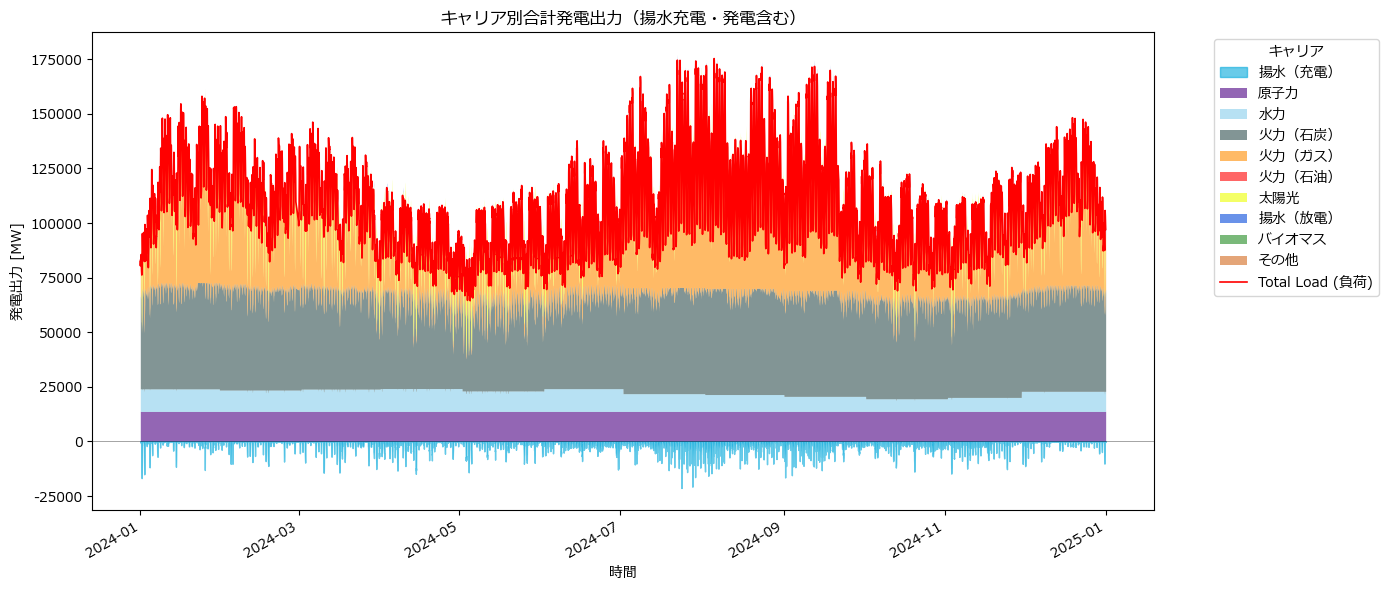

揚水発電システムの充放電状況:

揚水（放電）- 系統への発電量:
  総電力量（効率考慮後）: 8,291,737.16 MWh

揚水（充電）- 系統からの消費電力:
  総電力量（効率考慮前）: 9,796,475.85 MWh

サイクル効率: 84.64%


In [54]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード
import src.preprocess_data as preprocess_data
import src.analyze_results as analyze_results

importlib.reload(preprocess_data)
importlib.reload(analyze_results)
warnings.filterwarnings("ignore", category=UserWarning, module="pypsa")
# pandasの表示設定
pd.set_option('display.max_columns', None)
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024
demand_change_compared_to_2024 = 10  # %
file_name = "./data/raw/pypsa-japan-10BusModelV6.xlsx"  # ネットワーク＋需要データを含むExcelファイル

# スナップショット作成
snapshots = pd.date_range(f"{Year_of_analysis}-01-01 00:00",
                          f"{Year_of_analysis}-12-31 23:00",
                          freq="h")
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# ネットワークデータ読み込み
network = pypsa.Network(file_name)
network.set_snapshots(snapshots)

# 需要データ読み込み（同じExcelファイルの'Demand'シートから）
preprocess_data.import_demand_data_from_network_file(network, file_name, demand_change_compared_to_2024)

# 太陽光時系列データの読み込み
solar_data_file = './data/processed/solar_time_series.csv'
preprocess_data.SolarTimeSeriesDataSet(network, solar_data_file)

# 水力時系列データの読み込み
hydro_data_file = './data/processed/hydro_hourly.csv'
preprocess_data.HydroTimeSeriesDataSet(network, hydro_data_file)

# Ramp制約を追加する関数（PyPSA v1.0以降）
def add_ramp_constraints(n, snapshots):
    """
    Ramp制約を最適化モデルに追加
    - ramp_limit_up: 出力増加率の制限（p_nomに対する比率）
    - ramp_limit_down: 出力減少率の制限（p_nomに対する比率）
    """
    from linopy import Model
    


    # Linkコンポーネントに対するRamp制約
    if hasattr(n, 'links') and len(n.links) > 0:
        # ramp_limit_upが設定されているリンクを抽出
        links_with_ramp_up = n.links[n.links['ramp_limit_up'].notna() & (n.links['ramp_limit_up'] > 0)].index
        if len(links_with_ramp_up) > 0:
            # 出力の時間差分を計算
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp up制約: p(t) - p(t-1) <= ramp_limit_up * p_nom
            ramp_up_limit = n.links.loc[links_with_ramp_up, 'ramp_limit_up'] * n.links.loc[links_with_ramp_up, 'p_nom']
            n.model.add_constraints(
                p_diff.loc[:, links_with_ramp_up] <= ramp_up_limit,
                name="Link-ramp_limit_up"
            )
            print(f"  ✓ Ramp up制約を追加: {len(links_with_ramp_up)}個のリンク")
        
        # ramp_limit_downが設定されているリンクを抽出
        links_with_ramp_down = n.links[n.links['ramp_limit_down'].notna() & (n.links['ramp_limit_down'] > 0)].index
        if len(links_with_ramp_down) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp down制約: p(t-1) - p(t) <= ramp_limit_down * p_nom
            # つまり: -p_diff <= ramp_limit_down * p_nom
            ramp_down_limit = n.links.loc[links_with_ramp_down, 'ramp_limit_down'] * n.links.loc[links_with_ramp_down, 'p_nom']
            n.model.add_constraints(
                -p_diff.loc[:, links_with_ramp_down] <= ramp_down_limit,
                name="Link-ramp_limit_down"
            )
            print(f"  ✓ Ramp down制約を追加: {len(links_with_ramp_down)}個のリンク")

# 最適化実行（Ramp制約を有効化）
print("最適化を開始します...")
print("Ramp制約を追加中...")
network.optimize(
    solver_name='highs',
    extra_functionality=add_ramp_constraints
)
print("最適化が完了しました。")

# ネットワークデータ保存
network.export_to_netcdf(f'complete_network/optimized_network_{Year_of_analysis}.nc')

# 発電量集計・プロット
analyze_results.plot_total_generation_by_carrier(network)

# 揚水発電の総充電・総放電電力量を表示
pumped_hydro_links = network.links[network.links['carrier'].str.contains('揚水', na=False)]
if len(pumped_hydro_links) > 0:
    print("揚水発電システムの充放電状況:")
    print("="*60)
    
    # 放電（揚水発電）- 系統側の発電量(p1)を表示
    discharge_links = pumped_hydro_links[pumped_hydro_links['carrier'].str.contains('放電', na=False)]
    if len(discharge_links) > 0:
        # p1は負の値なので絶対値を取る
        discharge_total = abs(network.links_t.p1[discharge_links.index].sum().sum())
        print(f"\n揚水（放電）- 系統への発電量:")
        print(f"  総電力量（効率考慮後）: {discharge_total:,.2f} MWh")

    # 充電（揚水）- 系統からの消費電力(p0)を表示
    charge_links = pumped_hydro_links[pumped_hydro_links['carrier'].str.contains('充電', na=False)]
    if len(charge_links) > 0:
        charge_total = network.links_t.p0[charge_links.index].sum().sum()
        print(f"\n揚水（充電）- 系統からの消費電力:")
        print(f"  総電力量（効率考慮前）: {charge_total:,.2f} MWh")
    
    # サイクル効率を計算
    if len(discharge_links) > 0 and len(charge_links) > 0:
        cycle_efficiency = (discharge_total / charge_total) * 100
        print(f"\nサイクル効率: {cycle_efficiency:.2f}%")
else:
    print("揚水発電システムが見つかりませんでした。")